In [1]:
!pip install torchview
!pip install torcheval

  Obtaining dependency information for torcheval from https://files.pythonhosted.org/packages/e4/de/e7abc784b00de9d05999657d29187f1f7a3406ed10ecaf164de06482608f/torcheval-0.0.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 12.3 MB/s eta 0:00:00


# **Sexist Classification with BERT Embeddings using Multi-task Convolutional Neural Network**

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchview import draw_graph
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import Adam
from torcheval.metrics import MulticlassF1Score
from sklearn.metrics import classification_report
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.ERROR)

import os
datadir = '/kaggle/input/new-edos/data_6'
# datadir = '../../data_6'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LEVELS = np.array(['1', '2', '3_1', '3_2', '3_3', '3_4'])
BATCH_SIZE = 24

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## **Load Data**

In [3]:
train = pd.read_csv(os.path.join(datadir, 'train.csv'))
dev = pd.read_csv(os.path.join(datadir, 'dev.csv'))
test = pd.read_csv(os.path.join(datadir, 'test.csv'))

train.head()

,rewire_id,text,label_1,label_2,label_3,label_3_1,label_3_2,label_3_3,label_3_4,tokens
0,sexism2022_english-16993,"Then, she's a keeper. 😉",not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,"then , she's a keeper . :winking_face:"
1,sexism2022_english-13149,This is like the Metallica video where the poo...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,this is like the metallica video where the poo...
2,sexism2022_english-13021,woman?,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,woman ?
3,sexism2022_english-14998,Unlicensed day care worker reportedly tells co...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,unlicensed day care worker reportedly tells co...
4,sexism2022_english-7228,[USER] Leg day is easy. Hot girls who wear min...,sexist,3. animosity,3.3 backhanded gendered compliments,other,other,3.3 backhanded gendered compliments,other,user leg day is easy . hot girls who wear mini...


In [4]:
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
dev = dev.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

train.head()

,rewire_id,text,label_1,label_2,label_3,label_3_1,label_3_2,label_3_3,label_3_4,tokens
0,sexism2022_english-10017,She'll get a nice divorce settlement. Tiger Wo...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,she'll get a nice divorce settlement . tiger w...
1,sexism2022_english-10571,[URL] Here is another thread on it. I think it...,sexist,3. animosity,3.2 immutable gender differences and gender st...,other,other,3.2 immutable gender differences and gender st...,other,url here is another thread on it . i think its...
2,sexism2022_english-3800,one girl that I went to high school with liter...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,one girl that i went to high school with liter...
3,sexism2022_english-10977,Or change her name to a more fact base one lik...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,or change her name to a more fact base one lik...
4,sexism2022_english-8905,flat chested girls are little brothers to guys,sexist,2. derogation,2.1 descriptive attacks,other,2.1 descriptive attacks,other,other,flat chested girls are little brothers to guys


### Labels to categories

In [5]:
ALL_LABELS = []
for i in range(len(LEVELS)):
    ALL_LABELS.append(np.array(sorted(train[f'label_{LEVELS[i]}'].unique().tolist())))
ALL_LABELS = np.array(ALL_LABELS, dtype=object)
ALL_LABELS

array([array(['not sexist', 'sexist'], dtype='<U10'),
       array(['1. threats, plans to harm and incitement', '2. derogation',
              '3. animosity', '4. prejudiced discussions', 'not sexist'],
             dtype='<U40')                                                ,
       array(['1.1 threats of harm', '1.2 incitement and encouragement of harm',
              'not sexist', 'other'], dtype='<U40')                             ,
       array(['2.1 descriptive attacks', '2.2 aggressive and emotive attacks',
              '2.3 dehumanising attacks & overt sexual objectification',
              'not sexist', 'other'], dtype='<U55')                           ,
       array(['3.1 casual use of gendered slurs, profanities, and insults',
              '3.2 immutable gender differences and gender stereotypes',
              '3.3 backhanded gendered compliments',
              '3.4 condescending explanations or unwelcome advice', 'not sexist',
              'other'], dtype='<U58')     

In [6]:
def label_to_idx(label, level):
    return ALL_LABELS[level-1].tolist().index(label)

def idx_to_label(idx, level):
    return ALL_LABELS[level-1][idx]

label_to_idx('not sexist', 5), idx_to_label(2, 3)

(4, 'not sexist')

In [7]:
y_trains = torch.empty((len(train), len(LEVELS)), dtype=torch.long)
y_devs = torch.empty((len(dev), len(LEVELS)), dtype=torch.long)
y_tests = torch.empty((len(test), len(LEVELS)), dtype=torch.long)

for i in range(len(LEVELS)):
    y_trains[:, i] = torch.tensor(train[f'label_{LEVELS[i]}'].apply(lambda x: label_to_idx(x, i+1)).values, dtype=torch.long)
    y_devs[:, i] = torch.tensor(dev[f'label_{LEVELS[i]}'].apply(lambda x: label_to_idx(x, i+1)).values, dtype=torch.long)
    y_tests[:, i] = torch.tensor(test[f'label_{LEVELS[i]}'].apply(lambda x: label_to_idx(x, i+1)).values, dtype=torch.long)

y_trains.shape, y_devs.shape, y_tests.shape

(torch.Size([14000, 6]), torch.Size([2000, 6]), torch.Size([4000, 6]))

### Class weights

In [8]:
classes_weights = []
for i in range(len(LEVELS)):
    w = 1 / torch.bincount(y_trains[:, i]).float()
    w = w / w.sum()
    classes_weights.append(w.to(device))
classes_weights

[tensor([0.2427, 0.7573], device='cuda:0'),
 tensor([0.4130, 0.0805, 0.1099, 0.3845, 0.0121], device='cuda:0'),
 tensor([0.8039, 0.1772, 0.0042, 0.0146], device='cuda:0'),
 tensor([0.1635, 0.1742, 0.5863, 0.0111, 0.0649], device='cuda:0'),
 tensor([0.0379, 0.0579, 0.3773, 0.5138, 0.0023, 0.0108], device='cuda:0'),
 tensor([0.7563, 0.2199, 0.0054, 0.0185], device='cuda:0')]

## **BERT Embeddings**

In [9]:
# model_path = 'distilbert-base-uncased' # cpu
model_path = 'vinai/bertweet-base' # gpu

tokenizer = AutoTokenizer.from_pretrained(model_path)
bert_model = AutoModel.from_pretrained(model_path)

model_name = model_path.split('/')[-1]
assert len(model_name.split('/')) == 1

model_name

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

'bertweet-base'

### Padding by batch Dataset

In [10]:
class MiniBatchPaddingDataset(Dataset):
    def __init__(self, x, y, batch_size=BATCH_SIZE):
        self.y = y
        self.batch_size = batch_size

        # padding by max length in each batch
        self.num_batches = math.ceil(len(x) / self.batch_size)

        self.input_ids = []
        self.attention_masks = []
        
        for batch in range(self.num_batches):
            batch_start = batch * self.batch_size
            batch_end = min((batch + 1) * self.batch_size, len(x))

            batch_encodings = tokenizer(x[batch_start:batch_end], 
                                        padding=True, 
                                        max_length=120,
                                        truncation=True)
            batch_input_ids = batch_encodings['input_ids']
            batch_attention_mask = batch_encodings['attention_mask']

            self.input_ids += batch_input_ids
            self.attention_masks += batch_attention_mask
            

    def __getitem__(self, index):
        input_ids = torch.tensor(self.input_ids[index])
        attention_mask = torch.tensor(self.attention_masks[index])
        labels = torch.tensor(self.y[index])
        inputs = torch.stack((input_ids, attention_mask))

        return inputs, labels
    
    def __len__(self):
        return len(self.input_ids)

In [11]:
x_trains = train['text'].tolist()
x_devs = dev['text'].tolist()
x_tests = test['text'].tolist()

train_dataset = MiniBatchPaddingDataset(x_trains, y_trains)
dev_dataset = MiniBatchPaddingDataset(x_devs, y_devs)
test_dataset = MiniBatchPaddingDataset(x_tests, y_tests)

### Dataloader

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
for inputs, labels in train_loader:
    print(inputs.shape)
    print(labels.shape)

    break
    
bert_model(inputs[:, 0, :], inputs[:, 1, :])['last_hidden_state'].shape

torch.Size([24, 2, 64])
torch.Size([24, 6])


torch.Size([24, 64, 768])

### Embedding Layer

In [14]:
class BERT_Embedding(torch.nn.Module):
    def __init__(self, model):
        super(BERT_Embedding, self).__init__()
        self.bert_model = model

    def forward(self, input_ids, attention_mask):
        input_ids = input_ids
        attention_mask = attention_mask

        # inputs shape: (batch_size, max_seq_len)
        # outputs shape: (batch_size, max_seq_len, embedding_size)
        outputs = self.bert_model(input_ids, attention_mask)
        outputs = outputs['last_hidden_state']
        # print('bert embedding outputs:', outputs.shape)
        return outputs
    
    def __getitem__(self):
        return self.bert_model
        
    def get_embedding_size(self):
        return self.bert_model.config.hidden_size
    
    def get_embedding_dim(self):
        return self.bert_model.config.hidden_size


## **Model**

### **MultiConvos**

In [15]:
# multi convos layer
class MultiConvos(nn.Module):

    class GlobalMaxPool1d(nn.Module):
        def __init__(self):
            super(MultiConvos.GlobalMaxPool1d, self).__init__()

        def forward(self, inputs):
            return torch.max(inputs, dim=-1)[0]
       
    class ConcatTensor(nn.Module):
        def __init__(self):
            super(MultiConvos.ConcatTensor, self).__init__()

        def forward(self, inputs):
            return torch.cat(inputs, dim=1)

    
    def __init__(self, configs=None, dropout_concat=0, input_dim=None, **kwargs):
        super(MultiConvos, self).__init__(**kwargs)

        if input_dim is None:
            Exception('Please specify input_dim')

        if configs is None:
            self.configs = {3: {'filters': 32, 'dropout': 0.25},
                            4: {'filters': 32, 'dropout': 0.25},
                            5: {'filters': 32, 'dropout': 0.25}}
        else:
            self.configs = configs
            
        self.convs = nn.ModuleList()  # Use nn.ModuleList instead of a regular list
        for key in self.configs:
            # input shape: (batch_size, embedding_size, max_seq_len)
            # output shape: (batch_size, filters, max_seq_len)
            conv = nn.Conv1d(in_channels=input_dim, 
                             out_channels=int(self.configs[key]['filters']), 
                             kernel_size=int(key))
            nn.init.kaiming_normal_(conv.weight)
            if float(self.configs[key]['dropout']) > 0:
                dropout = nn.Dropout(p=float(self.configs[key]['dropout']))
            else:
                dropout = None

            # input shape: (batch_size, filters, max_seq_len)
            # output shape: (batch_size, filters)
            pool = MultiConvos.GlobalMaxPool1d()
            self.convs.append(nn.Sequential(conv, nn.ReLU(), dropout, pool))  # Apply activation function separately
#             self.convs.append(nn.Sequential(conv, dropout, pool))  # Apply activation function separately

        # self.concat = nn.Concatenate(dim=1)
        if dropout_concat > 0:
            self.dropout_concat = nn.Dropout(p=dropout_concat)
        else:
            self.dropout_concat = None

    def forward(self, inputs: torch.Tensor):
        # transpose to (batch_size, embedding_size, max_seq_len)
        # inputs = inputs.transpose(1, 2)
        inputs = inputs.permute(0, 2, 1)
        # print(inputs.shape)
        convs = []
        for i, key in enumerate(self.configs):
            # convolutional layer
            conv = self.convs[i][0](inputs)
            # activation function: ReLU
            conv = self.convs[i][1](conv)
            if self.convs[i][2] is not None:
                conv = self.convs[i][2](conv)
            # global max pooling
            conv = self.convs[i][3](conv)
#             print(conv.shape)
            convs.append(conv)
        # concat all convs
        concat = MultiConvos.ConcatTensor()(convs)
        if self.dropout_concat is not None:
            concat = self.dropout_concat(concat)
        return concat
    
    def __output_dim__(self):
        return sum([self.configs[key]['filters'] for key in self.configs])

### **Model**

In [16]:
class MultiTask_CNN_Model(nn.Module):
    def __init__(self, 
                 convo_configs=None, 
                 dropout_concat=0.1, 
                 dense_dim=128,
                 dropout_embedding=0.1,
                **kwargs):
        super(MultiTask_CNN_Model, self).__init__(**kwargs)
        
        self.bert_embedding = BERT_Embedding(bert_model)
        self.embedding_dropout = nn.Dropout(dropout_embedding)
        self.multi_convos = MultiConvos(convo_configs, 
                                        dropout_concat=dropout_concat,
                                        input_dim=self.bert_embedding.get_embedding_dim())
        self.denses = nn.ModuleList()
        self.FCs = nn.ModuleList()
        dense_input_size = self.multi_convos.__output_dim__()

        for i in range(0, len(LEVELS)):
            self.denses.append(nn.Sequential(nn.Linear(dense_input_size, dense_dim), 
                                             nn.ReLU(), nn.Dropout(0.2)))
#             self.FCs.append(nn.Sequential(nn.Linear(dense_dim, ALL_LABELS[i].shape[0]), 
#                                           nn.Softmax(dim=1)))
            self.FCs.append(nn.Linear(dense_dim, ALL_LABELS[i].shape[0]))
#             self.FCs.append(nn.Linear(dense_input_size, ALL_LABELS[i].shape[0]))

    def forward(self, inputs):
        bert_embedding = self.bert_embedding(inputs[:, 0, :], inputs[:, 1, :])
        bert_embedding = self.embedding_dropout(bert_embedding)
        multi_convos = self.multi_convos(bert_embedding)
#         print(multi_convos[:, 0])
        # print(multi_convos.shape)
        denses = []
        for i in range(0, len(LEVELS)):
            denses.append(self.denses[i](multi_convos))
        logits = []
        for i in range(0, len(LEVELS)):
            logits.append(self.FCs[i](denses[i]))
#             logits.append(self.FCs[i](multi_convos))
#         print(logits[0])
        return logits

## **Training**

### Losses and Metrics

In [17]:
def loss_fn(logits, labels, classes_weights, task_weights=None):
    losses = torch.zeros(len(LEVELS)).to(device)
    for i in range(len(LEVELS)):
        losses[i] = nn.functional.cross_entropy(logits[i], labels[:, i], 
                                                weight=classes_weights[i])
    
    predict_labels = []
    for i in range(len(LEVELS)):
        predict_labels.append(torch.argmax(logits[i], dim=1))


    # torch.where: for each sample in batch that matches the condition, return the index of the sample
    # torch.logical_and: for each sample in batch, return True if both conditions are True
    # torch.tensor: convert numpy array to tensor
    # idx_to_label: convert index to label
    # [0].shape[0]: get the number of samples in batch that matches the condition

    for i in range(1, len(LEVELS)):
        # if model 1 predicts not sexist and any other models predict sexist: other models loss * 10 (for each sample in batch)
        false_negatives = torch.where(torch.logical_and(torch.tensor(idx_to_label(predict_labels[0].cpu(), 1) == 'not sexist'), 
                                                        torch.tensor(idx_to_label(predict_labels[i].cpu(), i+1) != 'not sexist')
                                                        ))[0].shape[0]
        losses[i] *= 5 * false_negatives / BATCH_SIZE if false_negatives > 0 else 1

        # if model 1 predicts sexist and any other models predict not sexist: other models loss * 10 (for each sample in batch)
        false_positives = torch.where(torch.logical_and(torch.tensor(idx_to_label(predict_labels[0].cpu(), 1) == 'sexist'),
                                                        torch.tensor(idx_to_label(predict_labels[i].cpu(), i+1) == 'not sexist'))
                                    )[0].shape[0]
        losses[i] *= 5 * false_positives / BATCH_SIZE if false_positives > 0 else 1


    for i in range(2, len(LEVELS)):
        # print(i, LEVELS[i])
        # if model 2 predicts '{i-1}' and model 3_{i-1} predicts other: model 3_{i-1} loss * 10 (for each sample in batch)
        wrong = torch.where(torch.logical_and(torch.logical_and(torch.tensor(idx_to_label(predict_labels[0].cpu(), 1) == 'sexist'),
                                                                torch.tensor(idx_to_label(predict_labels[1].cpu(), 2) == str(i-1))),
                                            torch.tensor(idx_to_label(predict_labels[i].cpu(), i+1) != 'other'))
                            )[0].shape[0]
        losses[i] *= 5 * wrong / BATCH_SIZE if wrong > 0 else 1

        # if model 2 predicts '{i-1}' and any other models not 3_{i-1} don't predict other: other models loss * 10 (for each sample in batch)
        other_levels = np.setdiff1d(LEVELS, np.array(['1', '2', LEVELS[i]]))
        for level in other_levels:
            wrong_other = torch.where(torch.logical_and(torch.logical_and(torch.tensor(idx_to_label(predict_labels[0].cpu(), 1) == 'sexist'),
                                                                        torch.tensor(idx_to_label(predict_labels[1].cpu(), 2) == str(i-1))),
                                                        torch.tensor(idx_to_label(predict_labels[LEVELS.tolist().index(level)].cpu(), 
                                                                                  LEVELS.tolist().index(level) + 1) != 'other'))
                                    )[0].shape[0]
            losses[LEVELS.tolist().index(level)] *= 5 * wrong_other / BATCH_SIZE if wrong_other > 0 else 1

    if task_weights is None:
        loss = losses.sum()
    else:
        loss = (losses * task_weights).sum()

    return loss, losses

In [18]:
def multi_task_metrics_batch(logits_batch, labels_batch):
    batch_f1s = []
    metrics = [MulticlassF1Score(num_classes=ALL_LABELS[i].shape[0], average='macro', device=device) for i in range(len(LEVELS))]
    # calculate f1 score for each level by batch
    for i in range(len(LEVELS)):
        metrics[i].update(logits_batch[i], labels_batch[:, i])
        batch_f1s.append(metrics[i].compute())
    return batch_f1s

### Training and Evaluation

In [19]:
def train_epoch(model, loader, optimizer, device, classes_weights, task_weights):
    model.train()
    joint_losses = []
    multi_losses = []
    multi_f1s = []

    for batch in tqdm(loader):        
        logits = model(batch[0].to(device))
        labels = batch[1].to(device)
        joint_loss, multitask_losses = loss_fn(logits, labels, classes_weights, task_weights)
        
        joint_losses.append(joint_loss.item())
        multi_losses.append(multitask_losses)

        joint_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        f1s = multi_task_metrics_batch(logits, labels)
        multi_f1s.append(f1s)

    epoch_joint_loss = torch.mean(torch.tensor(joint_losses))

    epoch_multi_losses = []
    epoch_multi_f1s = []
    for i in range(len(LEVELS)):
        epoch_multi_losses.append(torch.mean(torch.tensor([loss[i].item() for loss in multi_losses])))
        epoch_multi_f1s.append(torch.mean(torch.tensor([f1[i] for f1 in multi_f1s])))

    return epoch_joint_loss, epoch_multi_losses, epoch_multi_f1s

In [20]:
def eval_epoch(model, loader, device, classes_weights, task_weights):
    model.eval()
    joint_losses = []
    multi_losses = []
    multi_f1s = []
    
    with torch.no_grad():
        for batch in tqdm(loader):
            logits = model(batch[0].to(device))
            labels = batch[1].to(device)
            joint_loss, multitask_losses = loss_fn(logits, labels, classes_weights, task_weights)
            
            joint_losses.append(joint_loss.item())
            multi_losses.append(multitask_losses)

            f1s = multi_task_metrics_batch(logits, labels)
            multi_f1s.append(f1s)
                        
    epoch_loss = torch.mean(torch.tensor(joint_losses), dim=0)
    epoch_multi_losses = []
    epoch_multi_f1s = []
    for i in range(len(LEVELS)):
        epoch_multi_losses.append(torch.mean(torch.tensor([loss[i].item() for loss in multi_losses])))
        epoch_multi_f1s.append(torch.mean(torch.tensor([f1[i] for f1 in multi_f1s])))

    return epoch_loss, epoch_multi_losses, epoch_multi_f1s

In [21]:
def train_and_validate(model, train_loader, dev_loader, optimizer, device, classes_weights, epochs=3, task_weights=None):
    train_losses = []
    train_multi_losses = []
    train_f1s = []
    dev_losses = []
    dev_multi_losses = []
    dev_f1s = []
    optimizer.zero_grad()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}')
        train_loss, train_multi_loss, train_f1 = train_epoch(model, train_loader, optimizer, device, classes_weights, task_weights)
        train_losses.append(train_loss)
        print(f'Train loss: {train_losses[-1]:.6f}')

        train_multi_losses.append(train_multi_loss)
        train_f1s.append(train_f1)
        for i in range(len(LEVELS)):
            print(f'> Level {LEVELS[i]}: loss {train_multi_losses[-1][i]:.5f}')
        
        dev_loss, dev_multi_loss, dev_f1 = eval_epoch(model, dev_loader, device, classes_weights, task_weights)
        dev_losses.append(dev_loss)
        print(f'Dev loss: {dev_losses[-1]:.5f}')

        dev_multi_losses.append(dev_multi_loss)
        dev_f1s.append(dev_f1)
        for i in range(len(LEVELS)):
            print(f'> Level {LEVELS[i]}: loss {dev_multi_losses[-1][i]:.5f}')
            
        print('=================== \n')
    
    return train_losses, train_multi_losses, train_f1s, dev_losses, dev_multi_losses, dev_f1s

### Config

In [22]:
print('device:', device)

multi_convos_config = {
    1: {'filters': 128, 'dropout': 0.5},
    2: {'filters': 256, 'dropout': 0.5},
    3: {'filters': 256, 'dropout': 0.5},
    4: {'filters': 128, 'dropout': 0.5},
    5: {'filters': 64, 'dropout': 0.5},
    6: {'filters': 64, 'dropout': 0.5}
}
    
model = MultiTask_CNN_Model(multi_convos_config, 
                            dense_dim=256, 
                            dropout_concat=0.5,
                            dropout_embedding=0.5)
model.to(device)
# print(model)

optimizer = Adam(model.parameters(), lr=5e-6, weight_decay=1e-8)

task_weights = torch.tensor([1.0, 1.5, 2.0, 2.0, 2.0, 2.0]).to(device)

device: cuda


### **Visualize Model**

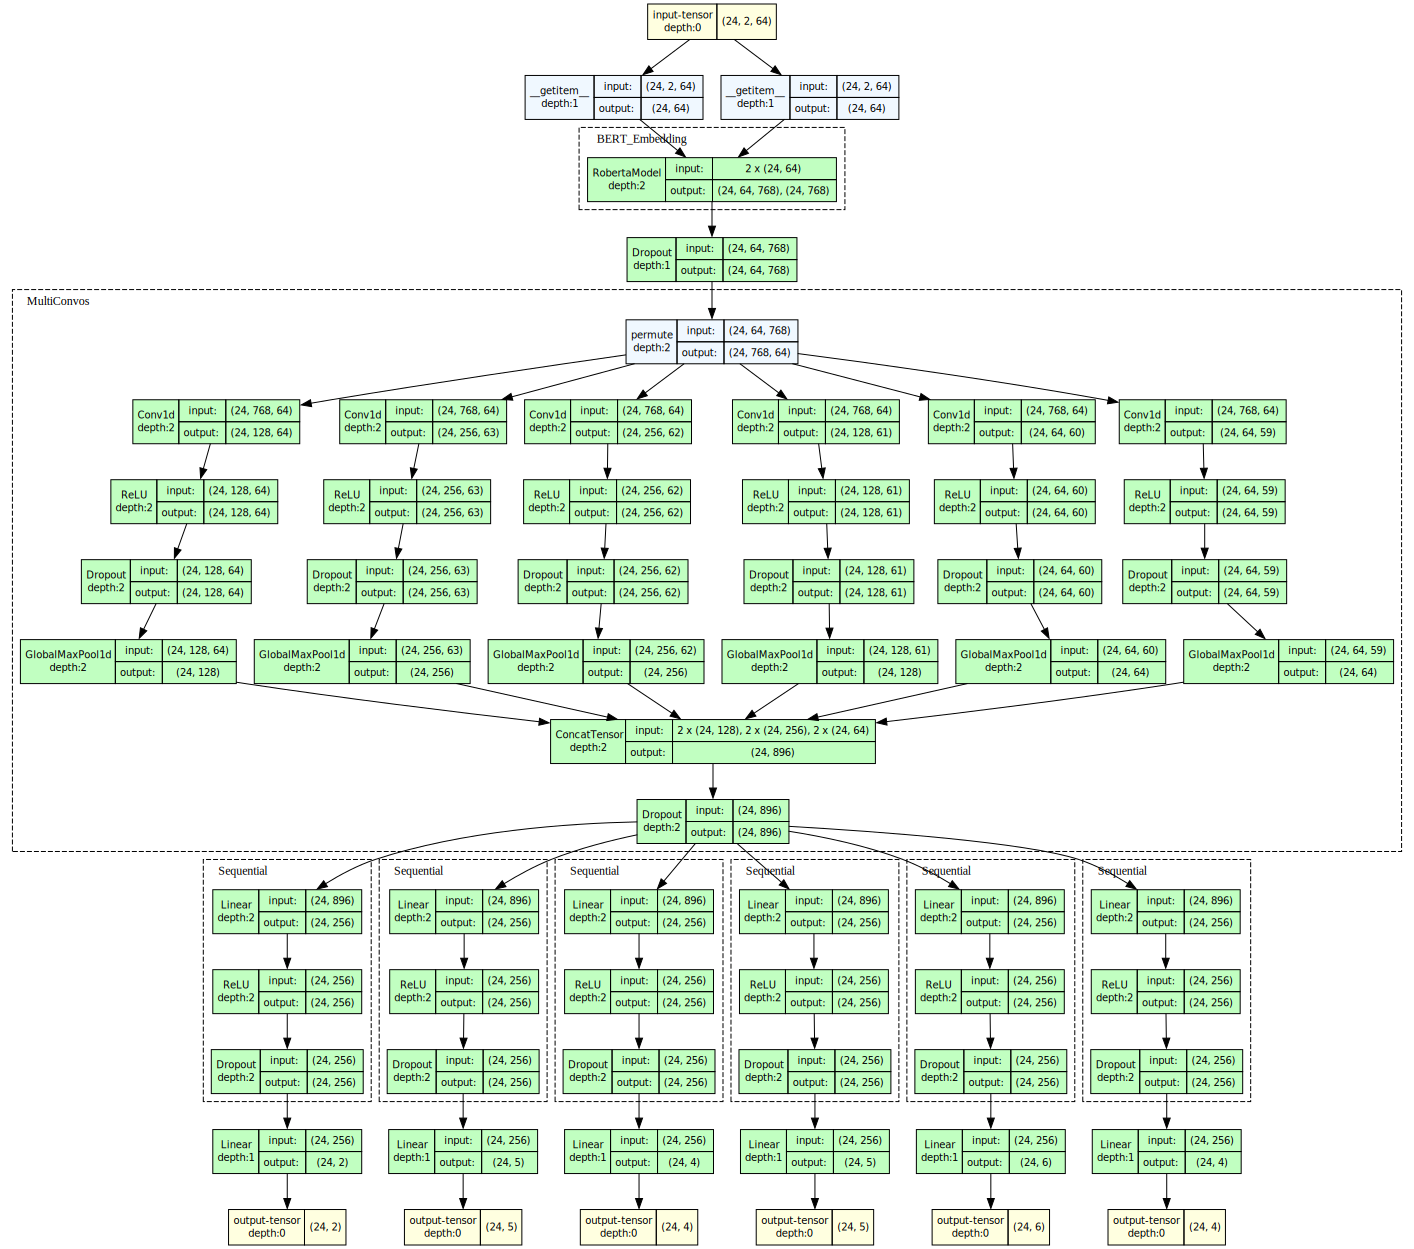

In [23]:
model_graph = draw_graph(model, 
                         input_data=(inputs),
                         expand_nested=True,
                         depth=2,
                         graph_name='MultiTask_CNN_Model',
                         save_graph=True)
model_graph.visual_graph

### Start training

In [24]:
EPOCHS = 30

train_losses, train_multi_losses, train_f1s, dev_losses, dev_multi_losses, dev_f1s = train_and_validate(model, 
                                                                                                        train_loader, dev_loader,
                                                                                                        optimizer, device, 
                                                                                                        classes_weights=classes_weights,
                                                                                                        epochs=EPOCHS,
                                                                                                        task_weights=task_weights)

Epoch 1


100%|██████████| 584/584 [01:46<00:00,  5.46it/s]


Train loss: 22.020157
> Level 1: loss 0.77562
> Level 2: loss 2.34330
> Level 3_1: loss 1.95306
> Level 3_2: loss 2.20828
> Level 3_3: loss 2.56775
> Level 3_4: loss 2.13571


100%|██████████| 84/84 [00:05<00:00, 16.05it/s]


Dev loss: 8.88594
> Level 1: loss 0.69187
> Level 2: loss 0.84361
> Level 3_1: loss 0.88380
> Level 3_2: loss 0.93319
> Level 3_3: loss 1.02248
> Level 3_4: loss 0.62486

Epoch 2


100%|██████████| 584/584 [01:46<00:00,  5.47it/s]


Train loss: 19.975014
> Level 1: loss 0.72551
> Level 2: loss 2.16781
> Level 3_1: loss 1.82197
> Level 3_2: loss 2.07005
> Level 3_3: loss 2.28239
> Level 3_4: loss 1.82449


100%|██████████| 84/84 [00:05<00:00, 15.83it/s]


Dev loss: 6.43526
> Level 1: loss 0.67975
> Level 2: loss 0.62396
> Level 3_1: loss 0.54101
> Level 3_2: loss 0.54157
> Level 3_3: loss 0.52735
> Level 3_4: loss 0.79985

Epoch 3


100%|██████████| 584/584 [01:47<00:00,  5.44it/s]


Train loss: 13.534686
> Level 1: loss 0.66393
> Level 2: loss 1.70768
> Level 3_1: loss 1.06893
> Level 3_2: loss 1.43537
> Level 3_3: loss 1.59428
> Level 3_4: loss 1.05604


100%|██████████| 84/84 [00:05<00:00, 15.98it/s]


Dev loss: 7.05303
> Level 1: loss 0.64162
> Level 2: loss 0.97942
> Level 3_1: loss 0.54506
> Level 3_2: loss 0.62493
> Level 3_3: loss 0.82437
> Level 3_4: loss 0.47678

Epoch 4


100%|██████████| 584/584 [01:47<00:00,  5.45it/s]


Train loss: 6.090767
> Level 1: loss 0.56373
> Level 2: loss 0.80372
> Level 3_1: loss 0.41516
> Level 3_2: loss 0.60750
> Level 3_3: loss 0.73754
> Level 3_4: loss 0.40053


100%|██████████| 84/84 [00:05<00:00, 15.90it/s]


Dev loss: 7.58186
> Level 1: loss 0.57136
> Level 2: loss 0.94381
> Level 3_1: loss 0.66523
> Level 3_2: loss 0.77847
> Level 3_3: loss 0.84241
> Level 3_4: loss 0.51127

Epoch 5


100%|██████████| 584/584 [01:47<00:00,  5.45it/s]


Train loss: 4.432605
> Level 1: loss 0.46922
> Level 2: loss 0.59845
> Level 3_1: loss 0.27188
> Level 3_2: loss 0.45423
> Level 3_3: loss 0.49497
> Level 3_4: loss 0.31177


100%|██████████| 84/84 [00:05<00:00, 15.87it/s]


Dev loss: 7.32477
> Level 1: loss 0.52219
> Level 2: loss 0.80709
> Level 3_1: loss 0.63501
> Level 3_2: loss 0.79244
> Level 3_3: loss 0.87568
> Level 3_4: loss 0.49284

Epoch 6


100%|██████████| 584/584 [01:47<00:00,  5.43it/s]


Train loss: 3.882925
> Level 1: loss 0.40939
> Level 2: loss 0.50998
> Level 3_1: loss 0.25185
> Level 3_2: loss 0.39380
> Level 3_3: loss 0.44618
> Level 3_4: loss 0.26245


100%|██████████| 84/84 [00:05<00:00, 15.85it/s]


Dev loss: 7.22652
> Level 1: loss 0.48755
> Level 2: loss 0.77047
> Level 3_1: loss 0.56272
> Level 3_2: loss 0.88015
> Level 3_3: loss 0.82758
> Level 3_4: loss 0.52118

Epoch 7


100%|██████████| 584/584 [01:47<00:00,  5.44it/s]


Train loss: 3.865915
> Level 1: loss 0.36687
> Level 2: loss 0.46383
> Level 3_1: loss 0.25960
> Level 3_2: loss 0.40347
> Level 3_3: loss 0.44811
> Level 3_4: loss 0.29047


100%|██████████| 84/84 [00:05<00:00, 15.96it/s]


Dev loss: 7.66854
> Level 1: loss 0.46527
> Level 2: loss 0.77922
> Level 3_1: loss 0.62198
> Level 3_2: loss 0.96401
> Level 3_3: loss 0.79750
> Level 3_4: loss 0.63373

Epoch 8


100%|██████████| 584/584 [01:47<00:00,  5.42it/s]


Train loss: 3.907800
> Level 1: loss 0.32086
> Level 2: loss 0.42168
> Level 3_1: loss 0.26555
> Level 3_2: loss 0.45937
> Level 3_3: loss 0.46851
> Level 3_4: loss 0.28378


100%|██████████| 84/84 [00:05<00:00, 15.63it/s]


Dev loss: 6.91266
> Level 1: loss 0.45100
> Level 2: loss 0.73851
> Level 3_1: loss 0.54166
> Level 3_2: loss 0.80084
> Level 3_3: loss 0.79008
> Level 3_4: loss 0.54437

Epoch 9


100%|██████████| 584/584 [01:48<00:00,  5.39it/s]


Train loss: 3.717730
> Level 1: loss 0.29105
> Level 2: loss 0.38660
> Level 3_1: loss 0.24686
> Level 3_2: loss 0.46908
> Level 3_3: loss 0.44742
> Level 3_4: loss 0.26002


100%|██████████| 84/84 [00:05<00:00, 15.77it/s]


Dev loss: 7.19189
> Level 1: loss 0.43798
> Level 2: loss 0.71981
> Level 3_1: loss 0.61145
> Level 3_2: loss 0.84964
> Level 3_3: loss 0.80751
> Level 3_4: loss 0.56848

Epoch 10


100%|██████████| 584/584 [01:47<00:00,  5.45it/s]


Train loss: 3.835577
> Level 1: loss 0.25434
> Level 2: loss 0.36611
> Level 3_1: loss 0.25703
> Level 3_2: loss 0.51340
> Level 3_3: loss 0.48342
> Level 3_4: loss 0.26218


100%|██████████| 84/84 [00:05<00:00, 15.68it/s]


Dev loss: 6.74654
> Level 1: loss 0.42821
> Level 2: loss 0.65014
> Level 3_1: loss 0.59013
> Level 3_2: loss 0.79070
> Level 3_3: loss 0.76510
> Level 3_4: loss 0.52564

Epoch 11


100%|██████████| 584/584 [01:47<00:00,  5.42it/s]


Train loss: 3.649428
> Level 1: loss 0.23079
> Level 2: loss 0.35775
> Level 3_1: loss 0.24905
> Level 3_2: loss 0.49531
> Level 3_3: loss 0.46030
> Level 3_4: loss 0.23635


100%|██████████| 84/84 [00:05<00:00, 15.72it/s]


Dev loss: 7.13992
> Level 1: loss 0.43008
> Level 2: loss 0.68819
> Level 3_1: loss 0.61635
> Level 3_2: loss 0.85265
> Level 3_3: loss 0.80320
> Level 3_4: loss 0.56659

Epoch 12


100%|██████████| 584/584 [01:47<00:00,  5.43it/s]


Train loss: 3.666031
> Level 1: loss 0.21471
> Level 2: loss 0.33247
> Level 3_1: loss 0.21983
> Level 3_2: loss 0.52077
> Level 3_3: loss 0.50586
> Level 3_4: loss 0.22985


100%|██████████| 84/84 [00:05<00:00, 15.78it/s]


Dev loss: 7.02313
> Level 1: loss 0.43526
> Level 2: loss 0.60685
> Level 3_1: loss 0.61015
> Level 3_2: loss 0.84846
> Level 3_3: loss 0.83956
> Level 3_4: loss 0.54063

Epoch 13


100%|██████████| 584/584 [01:47<00:00,  5.42it/s]


Train loss: 3.588262
> Level 1: loss 0.18945
> Level 2: loss 0.32456
> Level 3_1: loss 0.23010
> Level 3_2: loss 0.51067
> Level 3_3: loss 0.48652
> Level 3_4: loss 0.22870


100%|██████████| 84/84 [00:05<00:00, 15.64it/s]


Dev loss: 6.45668
> Level 1: loss 0.42796
> Level 2: loss 0.62234
> Level 3_1: loss 0.49211
> Level 3_2: loss 0.76744
> Level 3_3: loss 0.75849
> Level 3_4: loss 0.52956

Epoch 14


100%|██████████| 584/584 [01:47<00:00,  5.43it/s]


Train loss: 3.467331
> Level 1: loss 0.17815
> Level 2: loss 0.30748
> Level 3_1: loss 0.21250
> Level 3_2: loss 0.53338
> Level 3_3: loss 0.46745
> Level 3_4: loss 0.20065


100%|██████████| 84/84 [00:05<00:00, 15.76it/s]


Dev loss: 7.28296
> Level 1: loss 0.42724
> Level 2: loss 0.58930
> Level 3_1: loss 0.61548
> Level 3_2: loss 0.91279
> Level 3_3: loss 0.84295
> Level 3_4: loss 0.61466

Epoch 15


100%|██████████| 584/584 [01:47<00:00,  5.42it/s]


Train loss: 3.194836
> Level 1: loss 0.16053
> Level 2: loss 0.29875
> Level 3_1: loss 0.21067
> Level 3_2: loss 0.47671
> Level 3_3: loss 0.42174
> Level 3_4: loss 0.18397


100%|██████████| 84/84 [00:05<00:00, 15.85it/s]


Dev loss: 6.73331
> Level 1: loss 0.41717
> Level 2: loss 0.63743
> Level 3_1: loss 0.62477
> Level 3_2: loss 0.82589
> Level 3_3: loss 0.62926
> Level 3_4: loss 0.60008

Epoch 16


100%|██████████| 584/584 [01:47<00:00,  5.42it/s]


Train loss: 3.067363
> Level 1: loss 0.15260
> Level 2: loss 0.28134
> Level 3_1: loss 0.19391
> Level 3_2: loss 0.45879
> Level 3_3: loss 0.43359
> Level 3_4: loss 0.16009


100%|██████████| 84/84 [00:05<00:00, 15.70it/s]


Dev loss: 6.82027
> Level 1: loss 0.41565
> Level 2: loss 0.63980
> Level 3_1: loss 0.59984
> Level 3_2: loss 0.81536
> Level 3_3: loss 0.70543
> Level 3_4: loss 0.60183

Epoch 17


100%|██████████| 584/584 [01:47<00:00,  5.42it/s]


Train loss: 2.826512
> Level 1: loss 0.13507
> Level 2: loss 0.27234
> Level 3_1: loss 0.17000
> Level 3_2: loss 0.43409
> Level 3_3: loss 0.39244
> Level 3_4: loss 0.14493


100%|██████████| 84/84 [00:05<00:00, 15.66it/s]


Dev loss: 6.47450
> Level 1: loss 0.39706
> Level 2: loss 0.60500
> Level 3_1: loss 0.53960
> Level 3_2: loss 0.77034
> Level 3_3: loss 0.68132
> Level 3_4: loss 0.59372

Epoch 18


100%|██████████| 584/584 [01:47<00:00,  5.43it/s]


Train loss: 2.651730
> Level 1: loss 0.12323
> Level 2: loss 0.23839
> Level 3_1: loss 0.15680
> Level 3_2: loss 0.40830
> Level 3_3: loss 0.37808
> Level 3_4: loss 0.14228


100%|██████████| 84/84 [00:05<00:00, 15.72it/s]


Dev loss: 6.32566
> Level 1: loss 0.38734
> Level 2: loss 0.58772
> Level 3_1: loss 0.53757
> Level 3_2: loss 0.77039
> Level 3_3: loss 0.63179
> Level 3_4: loss 0.58862

Epoch 19


100%|██████████| 584/584 [01:47<00:00,  5.42it/s]


Train loss: 2.491777
> Level 1: loss 0.11535
> Level 2: loss 0.22882
> Level 3_1: loss 0.15331
> Level 3_2: loss 0.38423
> Level 3_3: loss 0.36034
> Level 3_4: loss 0.11872


100%|██████████| 84/84 [00:05<00:00, 15.69it/s]


Dev loss: 6.65011
> Level 1: loss 0.41816
> Level 2: loss 0.58234
> Level 3_1: loss 0.54932
> Level 3_2: loss 0.75698
> Level 3_3: loss 0.68157
> Level 3_4: loss 0.69136

Epoch 20


100%|██████████| 584/584 [01:47<00:00,  5.43it/s]


Train loss: 2.283329
> Level 1: loss 0.09599
> Level 2: loss 0.20762
> Level 3_1: loss 0.10765
> Level 3_2: loss 0.37214
> Level 3_3: loss 0.35216
> Level 3_4: loss 0.10601


100%|██████████| 84/84 [00:05<00:00, 15.67it/s]


Dev loss: 6.87998
> Level 1: loss 0.42476
> Level 2: loss 0.59524
> Level 3_1: loss 0.53099
> Level 3_2: loss 0.86480
> Level 3_3: loss 0.73016
> Level 3_4: loss 0.65523

Epoch 21


100%|██████████| 584/584 [01:47<00:00,  5.43it/s]


Train loss: 2.145269
> Level 1: loss 0.09258
> Level 2: loss 0.19777
> Level 3_1: loss 0.11240
> Level 3_2: loss 0.32850
> Level 3_3: loss 0.33410
> Level 3_4: loss 0.10302


100%|██████████| 84/84 [00:05<00:00, 15.66it/s]


Dev loss: 6.89438
> Level 1: loss 0.43821
> Level 2: loss 0.59874
> Level 3_1: loss 0.62274
> Level 3_2: loss 0.77309
> Level 3_3: loss 0.65887
> Level 3_4: loss 0.72433

Epoch 22


100%|██████████| 584/584 [01:47<00:00,  5.42it/s]


Train loss: 1.968612
> Level 1: loss 0.07957
> Level 2: loss 0.16402
> Level 3_1: loss 0.10070
> Level 3_2: loss 0.32776
> Level 3_3: loss 0.30834
> Level 3_4: loss 0.08471


100%|██████████| 84/84 [00:05<00:00, 15.80it/s]


Dev loss: 6.67404
> Level 1: loss 0.44536
> Level 2: loss 0.60465
> Level 3_1: loss 0.54039
> Level 3_2: loss 0.82822
> Level 3_3: loss 0.63196
> Level 3_4: loss 0.66028

Epoch 23


100%|██████████| 584/584 [01:47<00:00,  5.42it/s]


Train loss: 1.728854
> Level 1: loss 0.07845
> Level 2: loss 0.15157
> Level 3_1: loss 0.08269
> Level 3_2: loss 0.28881
> Level 3_3: loss 0.26895
> Level 3_4: loss 0.07107


100%|██████████| 84/84 [00:05<00:00, 15.75it/s]


Dev loss: 6.39513
> Level 1: loss 0.38492
> Level 2: loss 0.64953
> Level 3_1: loss 0.51353
> Level 3_2: loss 0.73256
> Level 3_3: loss 0.62852
> Level 3_4: loss 0.64334

Epoch 24


100%|██████████| 584/584 [01:47<00:00,  5.42it/s]


Train loss: 1.663054
> Level 1: loss 0.06905
> Level 2: loss 0.13960
> Level 3_1: loss 0.06825
> Level 3_2: loss 0.26978
> Level 3_3: loss 0.25672
> Level 3_4: loss 0.09755


100%|██████████| 84/84 [00:05<00:00, 15.62it/s]


Dev loss: 6.74173
> Level 1: loss 0.40710
> Level 2: loss 0.59315
> Level 3_1: loss 0.53091
> Level 3_2: loss 0.80566
> Level 3_3: loss 0.71346
> Level 3_4: loss 0.67243

Epoch 25


100%|██████████| 584/584 [01:47<00:00,  5.42it/s]


Train loss: 1.447800
> Level 1: loss 0.06567
> Level 2: loss 0.12654
> Level 3_1: loss 0.06738
> Level 3_2: loss 0.23496
> Level 3_3: loss 0.22554
> Level 3_4: loss 0.06828


100%|██████████| 84/84 [00:05<00:00, 15.76it/s]


Dev loss: 6.90208
> Level 1: loss 0.42856
> Level 2: loss 0.68612
> Level 3_1: loss 0.56536
> Level 3_2: loss 0.78101
> Level 3_3: loss 0.71797
> Level 3_4: loss 0.65783

Epoch 26


100%|██████████| 584/584 [01:47<00:00,  5.43it/s]


Train loss: 1.331202
> Level 1: loss 0.05716
> Level 2: loss 0.11504
> Level 3_1: loss 0.06421
> Level 3_2: loss 0.21525
> Level 3_3: loss 0.21032
> Level 3_4: loss 0.06096


100%|██████████| 84/84 [00:05<00:00, 15.84it/s]


Dev loss: 7.00833
> Level 1: loss 0.43308
> Level 2: loss 0.63383
> Level 3_1: loss 0.56387
> Level 3_2: loss 0.77961
> Level 3_3: loss 0.77729
> Level 3_4: loss 0.69149

Epoch 27


100%|██████████| 584/584 [01:47<00:00,  5.42it/s]


Train loss: 1.227286
> Level 1: loss 0.05459
> Level 2: loss 0.12062
> Level 3_1: loss 0.05955
> Level 3_2: loss 0.19769
> Level 3_3: loss 0.18010
> Level 3_4: loss 0.05855


100%|██████████| 84/84 [00:05<00:00, 15.69it/s]


Dev loss: 6.88944
> Level 1: loss 0.45692
> Level 2: loss 0.61335
> Level 3_1: loss 0.57605
> Level 3_2: loss 0.75823
> Level 3_3: loss 0.76781
> Level 3_4: loss 0.65416

Epoch 28


100%|██████████| 584/584 [01:47<00:00,  5.42it/s]


Train loss: 1.074448
> Level 1: loss 0.05264
> Level 2: loss 0.08788
> Level 3_1: loss 0.04607
> Level 3_2: loss 0.17418
> Level 3_3: loss 0.16282
> Level 3_4: loss 0.06191


100%|██████████| 84/84 [00:05<00:00, 15.83it/s]


Dev loss: 6.86006
> Level 1: loss 0.41115
> Level 2: loss 0.66116
> Level 3_1: loss 0.56316
> Level 3_2: loss 0.78595
> Level 3_3: loss 0.71268
> Level 3_4: loss 0.66680

Epoch 29


100%|██████████| 584/584 [01:47<00:00,  5.41it/s]


Train loss: 0.932573
> Level 1: loss 0.03640
> Level 2: loss 0.07934
> Level 3_1: loss 0.03808
> Level 3_2: loss 0.15755
> Level 3_3: loss 0.14902
> Level 3_4: loss 0.04394


100%|██████████| 84/84 [00:05<00:00, 15.72it/s]


Dev loss: 6.72677
> Level 1: loss 0.43775
> Level 2: loss 0.62076
> Level 3_1: loss 0.52014
> Level 3_2: loss 0.77557
> Level 3_3: loss 0.72130
> Level 3_4: loss 0.66193

Epoch 30


100%|██████████| 584/584 [01:47<00:00,  5.42it/s]


Train loss: 0.872956
> Level 1: loss 0.03582
> Level 2: loss 0.06687
> Level 3_1: loss 0.06093
> Level 3_2: loss 0.14647
> Level 3_3: loss 0.11933
> Level 3_4: loss 0.04168


100%|██████████| 84/84 [00:05<00:00, 15.69it/s]

Dev loss: 6.99466
> Level 1: loss 0.45944
> Level 2: loss 0.61914
> Level 3_1: loss 0.59711
> Level 3_2: loss 0.74461
> Level 3_3: loss 0.71064
> Level 3_4: loss 0.75090



### Plotting

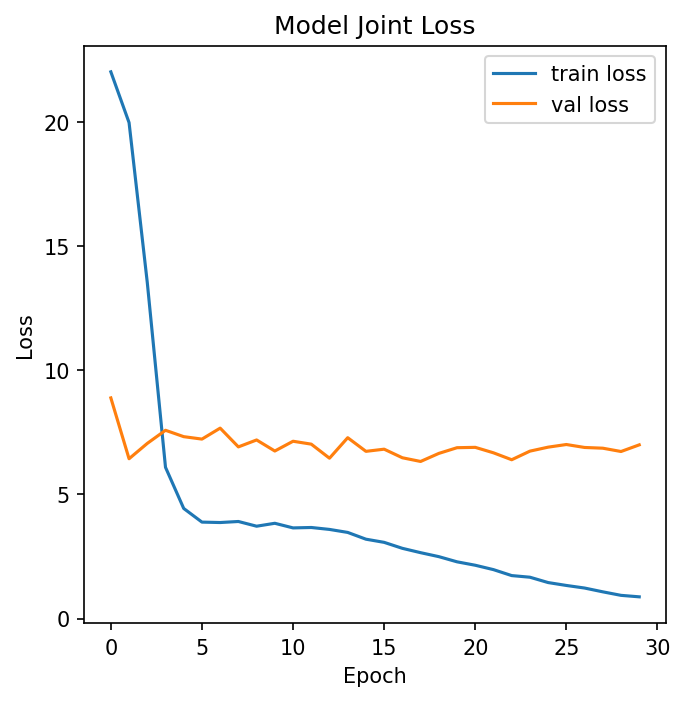

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5), dpi=150)

# losses
plt.plot(train_losses, label='train loss')
plt.plot(dev_losses, label='val loss')
plt.title('Model Joint Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(f'CNN_multi_torch_{model_name}_joint_loss.png')

plt.show()

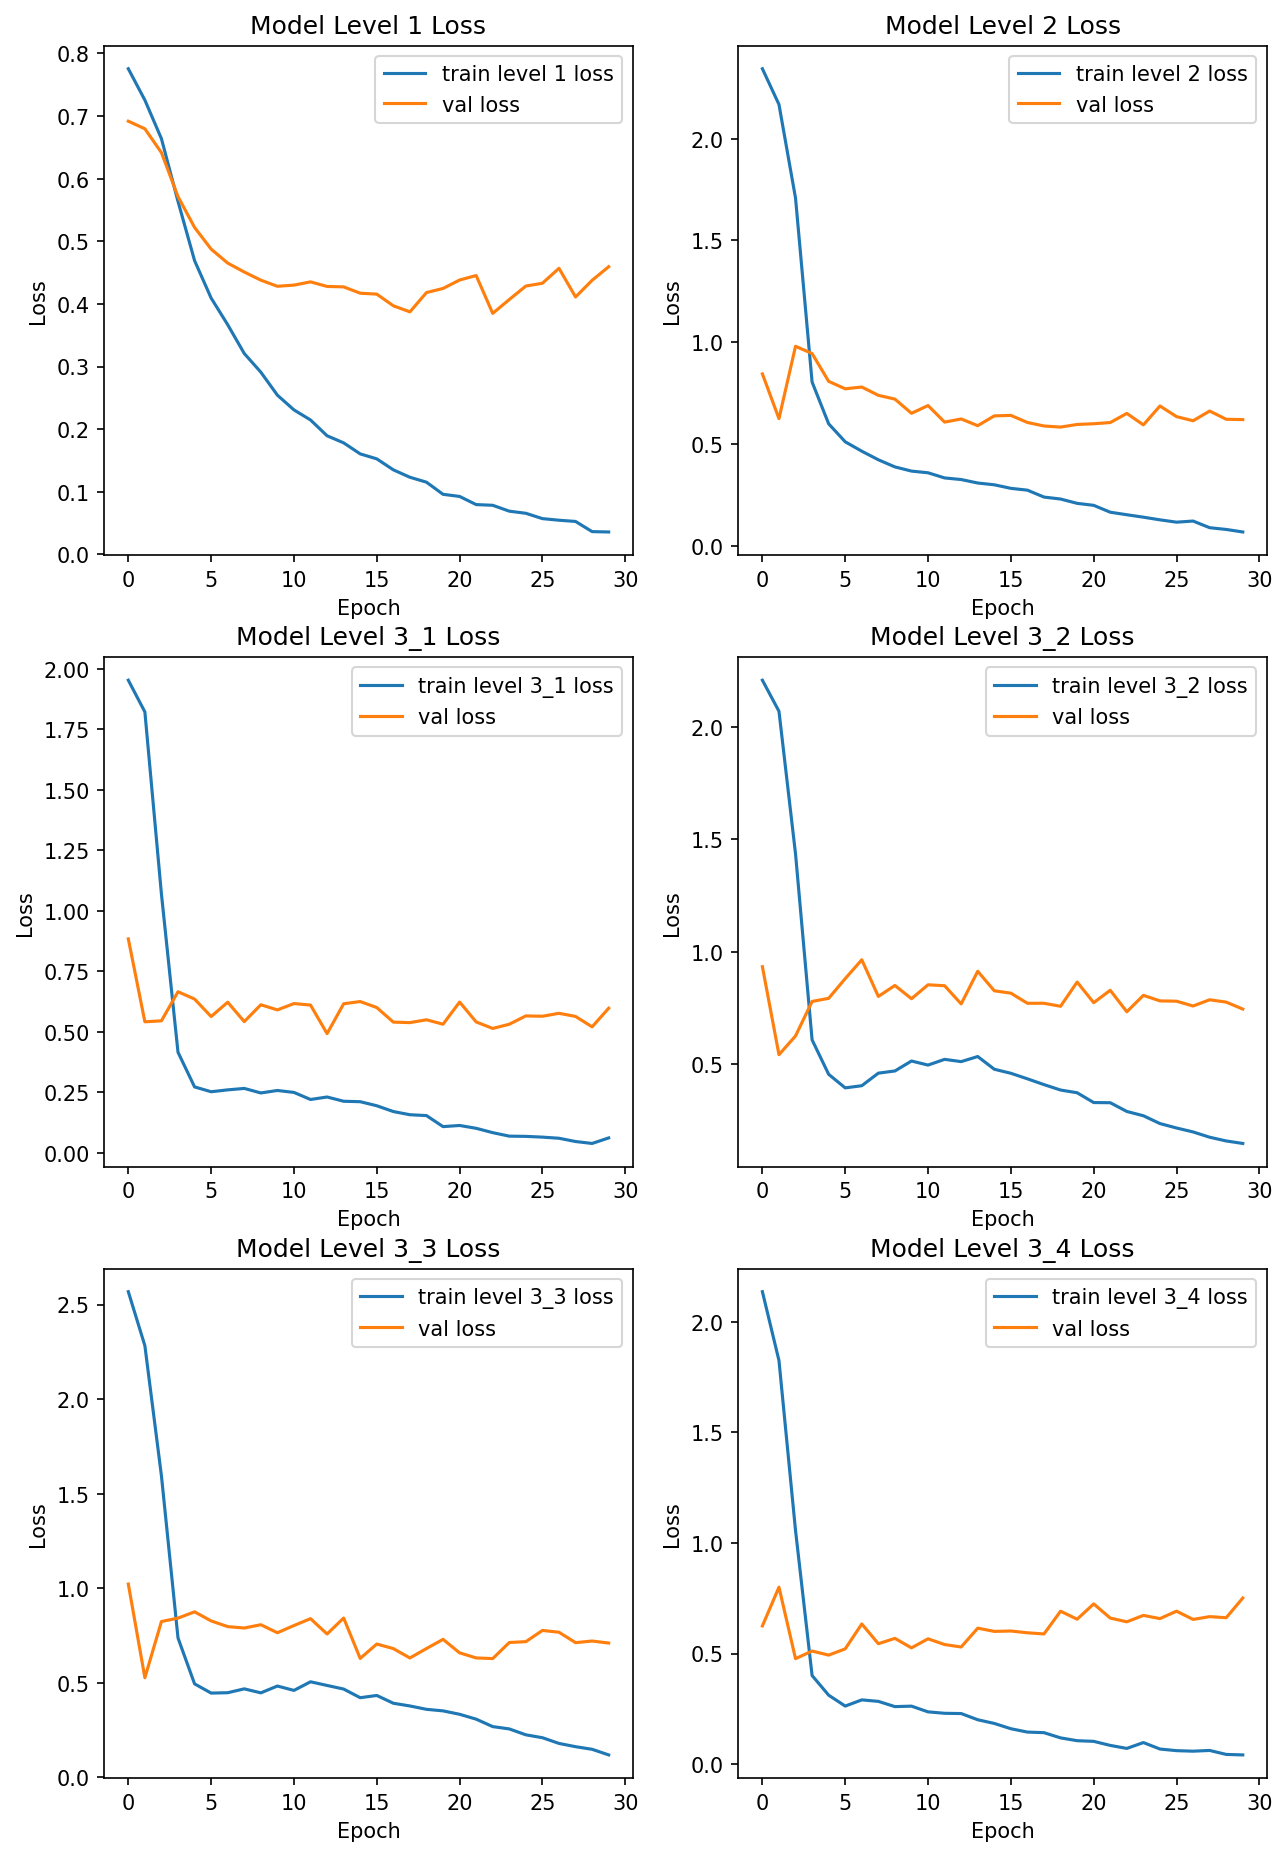

In [26]:
plt.figure(figsize=(10, 15), dpi=150)

# multi losses
for i in range(len(LEVELS)):
    plt.subplot(3, 2, i+1)
    plt.plot([loss[i] for loss in train_multi_losses], label=f'train level {LEVELS[i]} loss')
    plt.plot([loss[i] for loss in dev_multi_losses], label='val loss')
    plt.title(f'Model Level {LEVELS[i]} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

plt.savefig(f'CNN_multi_torch_{model_name}_multi_loss.png')

plt.show()

## **Predict**

In [27]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [28]:
test_preds = [[], [], [], [], [], []]

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        logits = model(batch[0].to(device))
        
        for i in range(len(LEVELS)):
            test_preds[i] += torch.argmax(logits[i], dim=1).tolist()
#         print('============ \n')
            
test_preds = torch.tensor(test_preds)
test_preds.shape

100%|██████████| 167/167 [00:08<00:00, 19.52it/s]


torch.Size([6, 4000])

In [29]:
for i in range(len(LEVELS)):
    test[f'pred_{LEVELS[i]}'] = [idx_to_label(idx, i+1) for idx in test_preds[i]]

test.to_csv(f'./{model_name}_test_preds.csv', index=False)
test.head()

,rewire_id,text,label_1,label_2,label_3,label_3_1,label_3_2,label_3_3,label_3_4,tokens,pred_1,pred_2,pred_3_1,pred_3_2,pred_3_3,pred_3_4
0,sexism2022_english-9019,"This year, Justin Timberlake should perform in...",not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,"this year , justin timberlake should perform i...",sexist,"1. threats, plans to harm and incitement",1.2 incitement and encouragement of harm,other,other,other
1,sexism2022_english-8150,"Osaka won youth beat old age, 20 vs 37. Serena...",sexist,3. animosity,"3.1 casual use of gendered slurs, profanities,...",other,other,"3.1 casual use of gendered slurs, profanities,...",other,"osaka won youth beat old age , 20 vs 37 . sere...",sexist,3. animosity,other,other,"3.1 casual use of gendered slurs, profanities,...",other
2,sexism2022_english-18136,Yeah the only way a man can satisfy those wome...,sexist,"1. threats, plans to harm and incitement",1.2 incitement and encouragement of harm,1.2 incitement and encouragement of harm,other,other,other,yeah the only way a man can satisfy those wome...,sexist,"1. threats, plans to harm and incitement",1.1 threats of harm,other,other,other
3,sexism2022_english-2602,Young girl 'passed around' to sleep with 100 m...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,young girl ' passed around ' to sleep with 100...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist
4,sexism2022_english-1479,You are an inspiration brother. I follow you o...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist,you are an inspiration brother . i follow you ...,not sexist,not sexist,not sexist,not sexist,not sexist,not sexist


In [30]:
def get_report(preds, labels):
    reports = []
    for i in range(len(LEVELS)):
        print(f'Level {LEVELS[i]}')
        # print('Labels:', labels[i].shape, 'Preds:', preds[i].shape)
        reports.append(classification_report(labels[i], preds[i], 
                                             target_names=ALL_LABELS[i], 
                                             digits=4, output_dict=True))
        print(classification_report(labels[i], preds[i], target_names=ALL_LABELS[i], digits=4))
    return reports

test_reports = get_report(test_preds, y_tests.T)
# print(test_reports, sep='\n')

Level 1
              precision    recall  f1-score   support

  not sexist     0.9149    0.9119    0.9134      3030
      sexist     0.7276    0.7351    0.7313       970

    accuracy                         0.8690      4000
   macro avg     0.8212    0.8235    0.8223      4000
weighted avg     0.8695    0.8690    0.8692      4000

Level 2
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement     0.4492    0.5955    0.5121        89
                           2. derogation     0.4829    0.5925    0.5321       454
                            3. animosity     0.4563    0.4865    0.4709       333
               4. prejudiced discussions     0.3441    0.3404    0.3422        94
                              not sexist     0.9305    0.8835    0.9064      3030

                                accuracy                         0.7983      4000
                               macro avg     0.5326    0.5797    0.5528      4000